# MARBERT v2 Fine-tuning with Multiple Configurations

This notebook trains and evaluates MARBERT v2 model on the preprocessed Arabic dataset with multiple configurations.

**Datasets**:
- Basic preprocessing: Arabic text with character normalization
- Advanced preprocessing: Arabic text with morphological segmentation

**Model**: MARBERT v2 (UBC-NLP/MARBERTv2)

**Task**: Binary classification (polarization detection)

**Goal**: Test different hyperparameter configurations to find the best performing setup

## Setup: Install Required Packages

In [3]:
!pip install transformers torch scikit-learn pandas numpy tqdm accelerate -q

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


## Load Datasets (Basic and Advanced Preprocessing)

In [5]:
# Load both datasets
# Note: Update the paths if running on Colab and data is uploaded
basic_path = 'arb_clean_basic.csv'
advanced_path = 'arb_clean_advanced.csv'

df_basic = pd.read_csv(basic_path)
df_advanced = pd.read_csv(advanced_path)

print("="*80)
print("BASIC PREPROCESSING DATASET")
print("="*80)
print(f"Shape: {df_basic.shape}")
print(f"Columns: {list(df_basic.columns)}")
print(f"\nFirst few rows:")
print(df_basic.head(3))
print(f"\nClass distribution:")
print(df_basic['polarization'].value_counts())
print(f"Class balance: {df_basic['polarization'].value_counts(normalize=True).to_dict()}")

print("\n" + "="*80)
print("ADVANCED PREPROCESSING DATASET")
print("="*80)
print(f"Shape: {df_advanced.shape}")
print(f"Columns: {list(df_advanced.columns)}")
print(f"\nFirst few rows:")
print(df_advanced.head(3))
print(f"\nClass distribution:")
print(df_advanced['polarization'].value_counts())
print(f"Class balance: {df_advanced['polarization'].value_counts(normalize=True).to_dict()}")

BASIC PREPROCESSING DATASET
Shape: (3380, 3)
Columns: ['id', 'text', 'polarization']

First few rows:
                                     id  \
0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
1  arb_6723e56a672674a6c1d9b28b213c4a05   
2  arb_b0365d606edeee38ae6c025b1ca33e96   

                                                text  polarization  
0  احلام انتي ونعالي ومنو انتي حتي تقيمين الفناني...             1  
1  وره الكواليس تنيجج من وره بعير صطناعي علي فكرة...             1  
2  .خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...             1  

Class distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64
Class balance: {0: 0.5526627218934911, 1: 0.44733727810650886}

ADVANCED PREPROCESSING DATASET
Shape: (3380, 3)
Columns: ['id', 'text', 'polarization']

First few rows:
                                     id  \
0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
1  arb_6723e56a672674a6c1d9b28b213c4a05   
2  arb_b0365d606edeee38ae6c025b1ca33e96   

                           

## Split Both Datasets (90/10 Train/Test with Stratification)

In [6]:
# Split with stratification to maintain class balance
RANDOM_STATE = 42

# Split basic preprocessing dataset
train_df_basic, test_df_basic = train_test_split(
    df_basic,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=df_basic['polarization']
)

# Split advanced preprocessing dataset
train_df_advanced, test_df_advanced = train_test_split(
    df_advanced,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=df_advanced['polarization']
)

print("BASIC PREPROCESSING DATASET SPLIT:")
print(f"Train set size: {len(train_df_basic)} ({len(train_df_basic)/len(df_basic)*100:.1f}%)")
print(f"Test set size: {len(test_df_basic)} ({len(test_df_basic)/len(df_basic)*100:.1f}%)")
print(f"Train class balance: {train_df_basic['polarization'].value_counts(normalize=True).to_dict()}")
print(f"Test class balance: {test_df_basic['polarization'].value_counts(normalize=True).to_dict()}")

print("\n" + "="*80)
print("\nADVANCED PREPROCESSING DATASET SPLIT:")
print(f"Train set size: {len(train_df_advanced)} ({len(train_df_advanced)/len(df_advanced)*100:.1f}%)")
print(f"Test set size: {len(test_df_advanced)} ({len(test_df_advanced)/len(df_advanced)*100:.1f}%)")
print(f"Train class balance: {train_df_advanced['polarization'].value_counts(normalize=True).to_dict()}")
print(f"Test class balance: {test_df_advanced['polarization'].value_counts(normalize=True).to_dict()}")

BASIC PREPROCESSING DATASET SPLIT:
Train set size: 3042 (90.0%)
Test set size: 338 (10.0%)
Train class balance: {0: 0.5525969756738988, 1: 0.44740302432610124}
Test class balance: {0: 0.5532544378698225, 1: 0.4467455621301775}


ADVANCED PREPROCESSING DATASET SPLIT:
Train set size: 3042 (90.0%)
Test set size: 338 (10.0%)
Train class balance: {0: 0.5525969756738988, 1: 0.44740302432610124}
Test class balance: {0: 0.5532544378698225, 1: 0.4467455621301775}


## Prepare Datasets for Training

In [7]:
# Convert to HuggingFace Dataset format for basic preprocessing
train_dataset_basic = Dataset.from_pandas(train_df_basic[['text', 'polarization']].rename(columns={'polarization': 'label'}))
test_dataset_basic = Dataset.from_pandas(test_df_basic[['text', 'polarization']].rename(columns={'polarization': 'label'}))

# Convert to HuggingFace Dataset format for advanced preprocessing
train_dataset_advanced = Dataset.from_pandas(train_df_advanced[['text', 'polarization']].rename(columns={'polarization': 'label'}))
test_dataset_advanced = Dataset.from_pandas(test_df_advanced[['text', 'polarization']].rename(columns={'polarization': 'label'}))

print("✓ Datasets prepared")
print(f"\nBasic Preprocessing:")
print(f"  Train dataset: {train_dataset_basic}")
print(f"  Test dataset: {test_dataset_basic}")
print(f"\nAdvanced Preprocessing:")
print(f"  Train dataset: {train_dataset_advanced}")
print(f"  Test dataset: {test_dataset_advanced}")

✓ Datasets prepared

Basic Preprocessing:
  Train dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3042
})
  Test dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 338
})

Advanced Preprocessing:
  Train dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3042
})
  Test dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 338
})


## Helper Functions for Training and Evaluation

In [8]:
def tokenize_function(examples, tokenizer):
    """Tokenize the texts"""
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

def evaluate_model(trainer, test_dataset, config_name):
    """Evaluate model and return detailed metrics"""
    # Get predictions
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)

    return {
        'config': config_name,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': predictions,
        'confusion_matrix': cm,
        'true_labels': labels,
        'pred_labels': preds
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## Training Configurations

Define multiple hyperparameter configurations to test with MARBERT v2

In [9]:
# Define multiple training configurations to test
training_configs = [
    {
        'name': 'Config 1: Baseline',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 5e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 2: More Epochs',
        'num_train_epochs': 5,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 5e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 3: Smaller Batch',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 8,
        'per_device_eval_batch_size': 16,
        'learning_rate': 5e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 4: Lower Learning Rate',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 2e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 5: Higher Weight Decay',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 5e-5,
        'warmup_steps': 500,
        'weight_decay': 0.05,
    },
    {
        'name': 'Config 6: More Warmup',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 5e-5,
        'warmup_steps': 1000,
        'weight_decay': 0.01,
    },
]

print("Training Configurations:")
print("="*80)
for i, config in enumerate(training_configs, 1):
    print(f"\n{config['name']}")
    for key, value in config.items():
        if key != 'name':
            print(f"  {key}: {value}")
print("="*80)

Training Configurations:

Config 1: Baseline
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 5e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 2: More Epochs
  num_train_epochs: 5
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 5e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 3: Smaller Batch
  num_train_epochs: 3
  per_device_train_batch_size: 8
  per_device_eval_batch_size: 16
  learning_rate: 5e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 4: Lower Learning Rate
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 2e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 5: Higher Weight Decay
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 5e-05
  warmup_steps: 500
  weight_decay: 0.05

Config 6: More Warmup
  num_train_epochs: 3
  per_device_train_batch_size: 16
  

## Train and Evaluate All Configurations

Now we'll train MARBERT v2 with each configuration on both datasets and track results

In [10]:
# Model name
model_name = "UBC-NLP/MARBERTv2"

# Store all results
all_results = []

# Train on both datasets with all configurations
datasets = [
    ('Basic', train_dataset_basic, test_dataset_basic),
    ('Advanced', train_dataset_advanced, test_dataset_advanced)
]

for dataset_name, train_dataset, test_dataset in datasets:
    print("\n" + "="*80)
    print(f"Training on {dataset_name} Preprocessing Dataset")
    print("="*80)

    for config in training_configs:
        print(f"\n{'='*80}")
        print(f"{config['name']} - {dataset_name} Preprocessing")
        print(f"{'='*80}")

        # Load fresh model for each configuration
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )

        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Tokenize datasets
        tokenized_train = train_dataset.map(
            lambda x: tokenize_function(x, tokenizer),
            batched=True
        )
        tokenized_test = test_dataset.map(
            lambda x: tokenize_function(x, tokenizer),
            batched=True
        )

        # Create data collator
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

        # Set up training arguments
        training_args = TrainingArguments(
            output_dir=f'./results_{dataset_name.lower()}_{config["name"].replace(" ", "_").replace(":", "")}',
            num_train_epochs=config['num_train_epochs'],
            per_device_train_batch_size=config['per_device_train_batch_size'],
            per_device_eval_batch_size=config['per_device_eval_batch_size'],
            learning_rate=config['learning_rate'],
            warmup_steps=config['warmup_steps'],
            weight_decay=config['weight_decay'],
            logging_dir=f'./logs_{dataset_name.lower()}_{config["name"].replace(" ", "_").replace(":", "")}',
            logging_steps=100,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            seed=RANDOM_STATE
        )

        # Create Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_test,
            compute_metrics=compute_metrics,
            data_collator=data_collator
        )

        # Train
        print(f"\nTraining {config['name']} on {dataset_name} dataset...")
        trainer.train()

        # Evaluate
        results = evaluate_model(trainer, tokenized_test, f"{config['name']} - {dataset_name}")
        results['dataset'] = dataset_name
        results['preprocessing'] = dataset_name
        all_results.append(results)

        print(f"\nResults:")
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  F1 Score: {results['f1']:.4f}")

        # Clear GPU memory
        del model
        del trainer
        torch.cuda.empty_cache()

print("\n" + "="*80)
print("ALL TRAINING COMPLETED!")
print("="*80)


Training on Basic Preprocessing Dataset

Config 1: Baseline - Basic Preprocessing


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 1: Baseline on Basic dataset...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nuh-alsharafi (deepclean415445) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.657900,0.385708,0.831361,0.831592
2,0.337200,0.434570,0.813609,0.813549
3,0.272000,0.665113,0.828402,0.828402



Results:
  Accuracy: 0.8314
  F1 Score: 0.8316

Config 2: More Epochs - Basic Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 2: More Epochs on Basic dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.648700,0.393840,0.813609,0.813270
2,0.337300,0.505711,0.795858,0.793422
3,0.226800,0.484422,0.816568,0.816859
4,0.124300,0.882525,0.822485,0.822933
5,0.028600,0.995740,0.825444,0.825756



Results:
  Accuracy: 0.8254
  F1 Score: 0.8258

Config 3: Smaller Batch - Basic Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 3: Smaller Batch on Basic dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.431800,0.428691,0.786982,0.785648
2,0.332600,0.511382,0.816568,0.815229
3,0.125800,0.909668,0.819527,0.819583



Results:
  Accuracy: 0.8195
  F1 Score: 0.8196

Config 4: Lower Learning Rate - Basic Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 4: Lower Learning Rate on Basic dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682100,0.414093,0.837278,0.837567
2,0.377600,0.382357,0.825444,0.825866
3,0.251200,0.482421,0.810651,0.811164



Results:
  Accuracy: 0.8373
  F1 Score: 0.8376

Config 5: Higher Weight Decay - Basic Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 5: Higher Weight Decay on Basic dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.648700,0.392607,0.822485,0.822366
2,0.342100,0.481553,0.798817,0.795961
3,0.235900,0.636328,0.819527,0.820001



Results:
  Accuracy: 0.8225
  F1 Score: 0.8224

Config 6: More Warmup - Basic Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 6: More Warmup on Basic dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.677300,0.397893,0.816568,0.817090
2,0.363900,0.390465,0.828402,0.828739
3,0.250900,0.462903,0.813609,0.813110



Results:
  Accuracy: 0.8284
  F1 Score: 0.8287

Training on Advanced Preprocessing Dataset

Config 1: Baseline - Advanced Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 1: Baseline on Advanced dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654900,0.383893,0.828402,0.828890
2,0.347000,0.487361,0.795858,0.793422
3,0.287000,0.623656,0.810651,0.810651



Results:
  Accuracy: 0.8284
  F1 Score: 0.8289

Config 2: More Epochs - Advanced Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 2: More Epochs on Advanced dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654900,0.383893,0.828402,0.828890
2,0.347000,0.487361,0.795858,0.793422
3,0.287000,0.586038,0.798817,0.798531
4,0.132000,1.029588,0.804734,0.802192
5,0.031800,1.052323,0.807692,0.807493



Results:
  Accuracy: 0.8284
  F1 Score: 0.8289

Config 3: Smaller Batch - Advanced Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 3: Smaller Batch on Advanced dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.428100,0.433656,0.801775,0.801414
2,0.355800,0.529948,0.807692,0.808224
3,0.149300,0.960225,0.810651,0.810765



Results:
  Accuracy: 0.8107
  F1 Score: 0.8108

Config 4: Lower Learning Rate - Advanced Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 4: Lower Learning Rate on Advanced dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.685600,0.421627,0.828402,0.828505
2,0.392300,0.386887,0.834320,0.834791
3,0.276800,0.467781,0.807692,0.807752



Results:
  Accuracy: 0.8343
  F1 Score: 0.8348

Config 5: Higher Weight Decay - Advanced Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 5: Higher Weight Decay on Advanced dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654900,0.383812,0.828402,0.828885
2,0.345800,0.473004,0.789941,0.787121
3,0.216000,0.630028,0.798817,0.799214



Results:
  Accuracy: 0.8284
  F1 Score: 0.8289

Config 6: More Warmup - Advanced Preprocessing


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 6: More Warmup on Advanced dataset...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.680900,0.404104,0.831361,0.831507
2,0.378200,0.397756,0.828402,0.828505
3,0.272700,0.454696,0.813609,0.814008


RuntimeError: [enforce fail at inline_container.cc:664] . unexpected pos 307255296 vs 307255184

## Compare All Results

In [11]:
# Create comparison DataFrame
results_df = pd.DataFrame([
    {
        'Configuration': r['config'],
        'Dataset': r['preprocessing'],
        'Accuracy': r['accuracy'],
        'F1 Score': r['f1']
    }
    for r in all_results
])

# Sort by F1 score
results_df = results_df.sort_values('F1 Score', ascending=False)

print("\n" + "="*80)
print("COMPLETE RESULTS COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best configuration
best_result = results_df.iloc[0]
print(f"\n🏆 BEST CONFIGURATION:")
print(f"   {best_result['Configuration']}")
print(f"   Dataset: {best_result['Dataset']} Preprocessing")
print(f"   Accuracy: {best_result['Accuracy']:.4f}")
print(f"   F1 Score: {best_result['F1 Score']:.4f}")


COMPLETE RESULTS COMPARISON
                           Configuration  Dataset  Accuracy  F1 Score
   Config 4: Lower Learning Rate - Basic    Basic  0.837278  0.837567
Config 4: Lower Learning Rate - Advanced Advanced  0.834320  0.834791
              Config 1: Baseline - Basic    Basic  0.831361  0.831592
        Config 2: More Epochs - Advanced Advanced  0.828402  0.828890
           Config 1: Baseline - Advanced Advanced  0.828402  0.828890
Config 5: Higher Weight Decay - Advanced Advanced  0.828402  0.828885
           Config 6: More Warmup - Basic    Basic  0.828402  0.828739
           Config 2: More Epochs - Basic    Basic  0.825444  0.825756
   Config 5: Higher Weight Decay - Basic    Basic  0.822485  0.822366
         Config 3: Smaller Batch - Basic    Basic  0.819527  0.819583
      Config 3: Smaller Batch - Advanced Advanced  0.810651  0.810765

🏆 BEST CONFIGURATION:
   Config 4: Lower Learning Rate - Basic
   Dataset: Basic Preprocessing
   Accuracy: 0.8373
   F1 Score: 0.

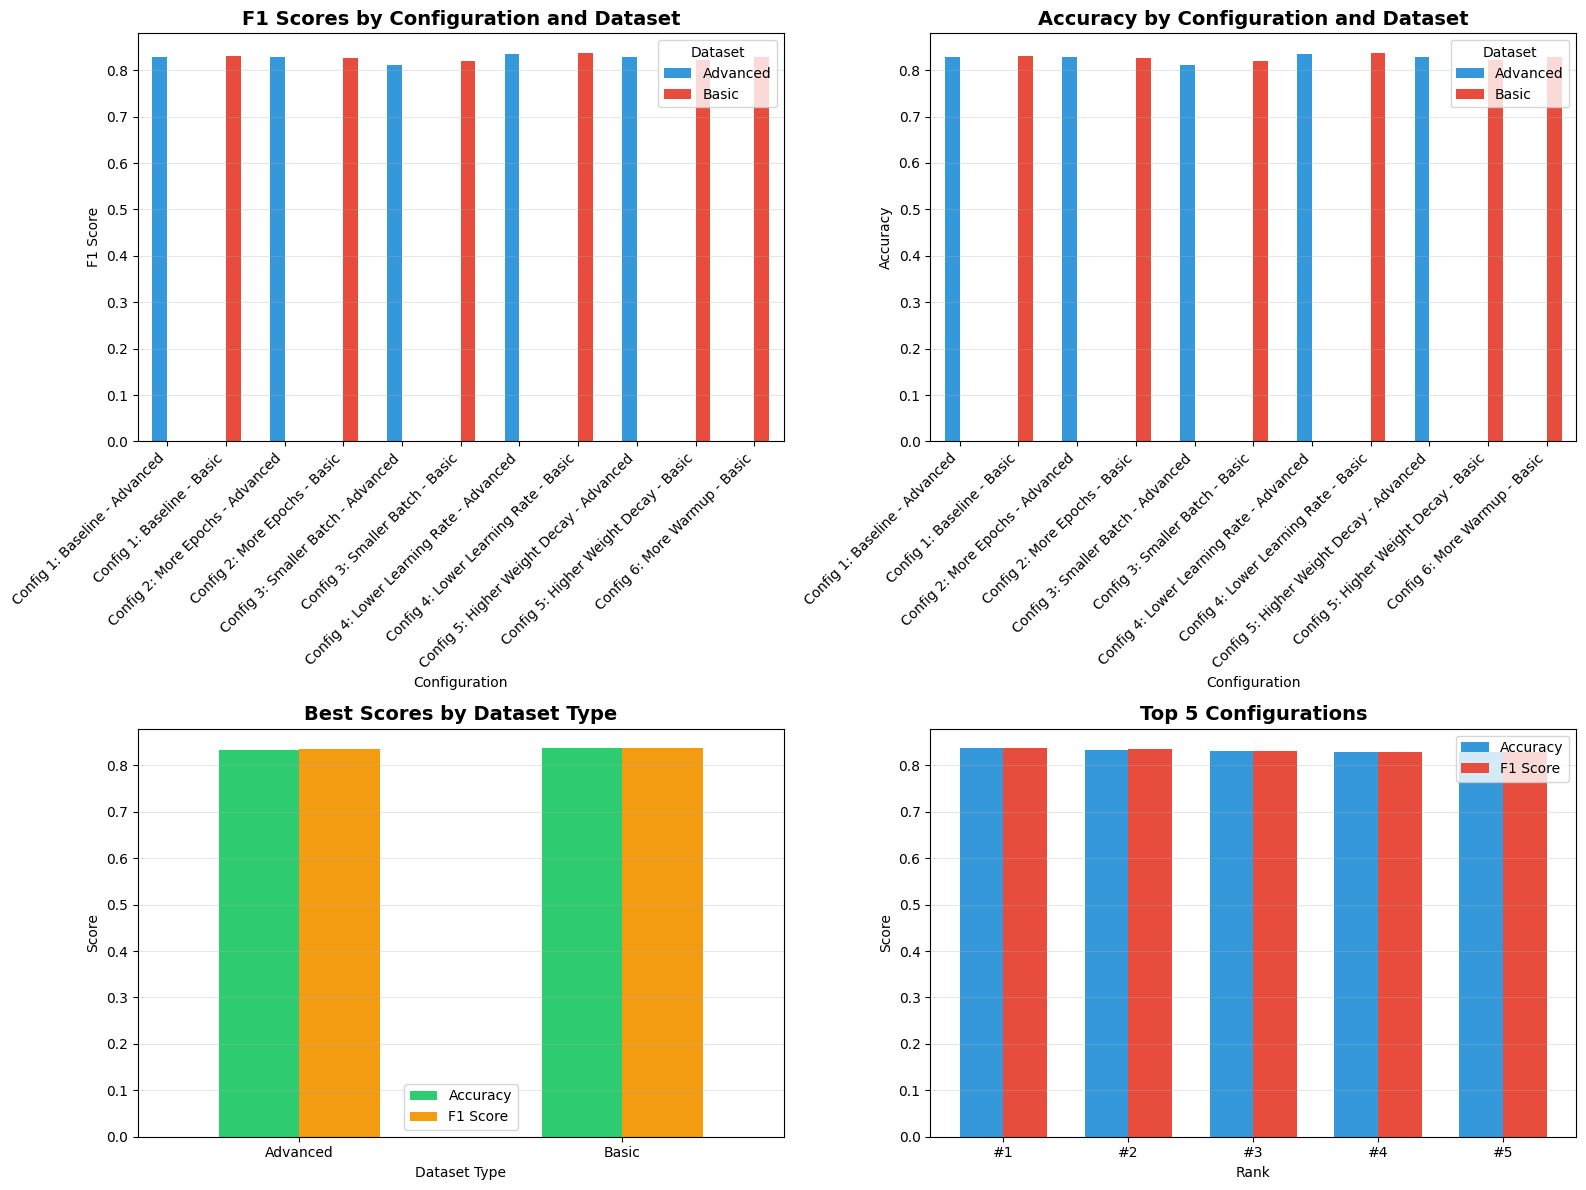


✓ Visualization complete


In [12]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 Scores by Configuration and Dataset
ax1 = axes[0, 0]
results_pivot = results_df.pivot(index='Configuration', columns='Dataset', values='F1 Score')
results_pivot.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'])
ax1.set_title('F1 Scores by Configuration and Dataset', fontsize=14, fontweight='bold')
ax1.set_ylabel('F1 Score')
ax1.set_xlabel('Configuration')
ax1.legend(title='Dataset')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Accuracy Scores by Configuration and Dataset
ax2 = axes[0, 1]
accuracy_pivot = results_df.pivot(index='Configuration', columns='Dataset', values='Accuracy')
accuracy_pivot.plot(kind='bar', ax=ax2, color=['#3498db', '#e74c3c'])
ax2.set_title('Accuracy by Configuration and Dataset', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Configuration')
ax2.legend(title='Dataset')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Best scores by dataset
ax3 = axes[1, 0]
best_by_dataset = results_df.groupby('Dataset')[['Accuracy', 'F1 Score']].max()
best_by_dataset.plot(kind='bar', ax=ax3, color=['#2ecc71', '#f39c12'])
ax3.set_title('Best Scores by Dataset Type', fontsize=14, fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Dataset Type')
ax3.legend(['Accuracy', 'F1 Score'])
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

# 4. Performance comparison - Top 5
ax4 = axes[1, 1]
top5 = results_df.head(5)
x = range(len(top5))
width = 0.35
ax4.bar([i - width/2 for i in x], top5['Accuracy'], width, label='Accuracy', color='#3498db')
ax4.bar([i + width/2 for i in x], top5['F1 Score'], width, label='F1 Score', color='#e74c3c')
ax4.set_title('Top 5 Configurations', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score')
ax4.set_xlabel('Rank')
ax4.set_xticks(x)
ax4.set_xticklabels([f"#{i+1}" for i in x])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## Confusion Matrices for All Configurations

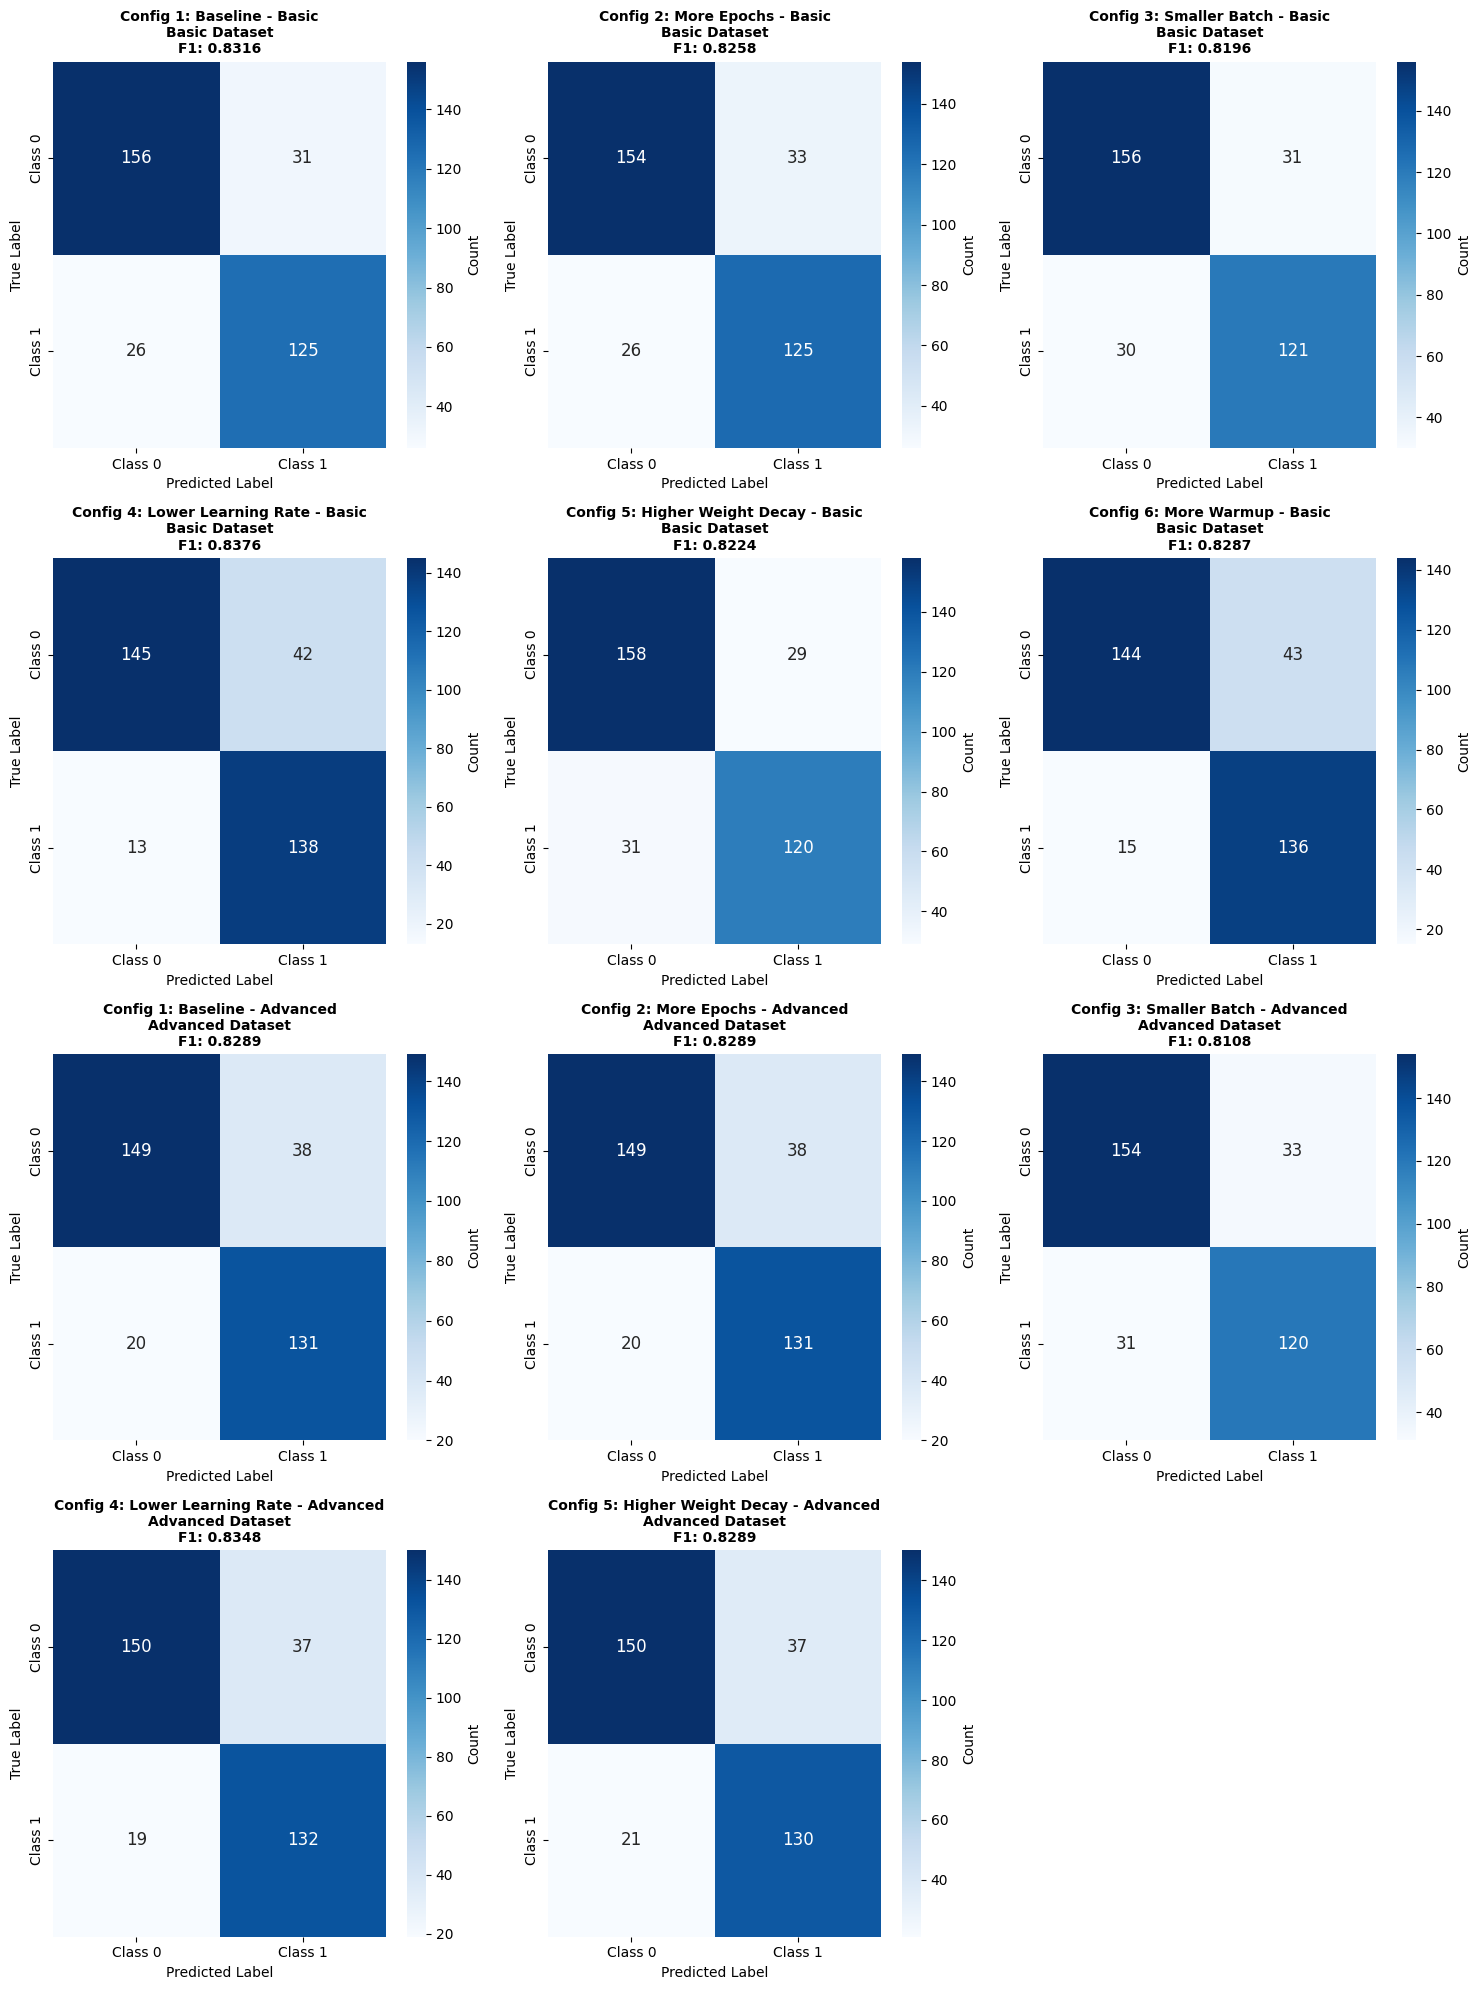


✓ Displayed 11 confusion matrices


In [13]:
# Create a grid of confusion matrices for all configurations
n_results = len(all_results)
n_cols = 3
n_rows = (n_results + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_results > 1 else [axes]

for idx, result in enumerate(all_results):
    ax = axes[idx]
    cm = result['confusion_matrix']

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 12})

    # Set labels
    ax.set_title(f"{result['config']}\n{result['dataset']} Dataset\nF1: {result['f1']:.4f}",
                 fontsize=10, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'])

# Hide any unused subplots
for idx in range(n_results, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Displayed {n_results} confusion matrices")

## Detailed Classification Reports

In [14]:
# Print classification reports for all configurations
for result in all_results:
    print("\n" + "="*80)
    print(f"{result['config']} - {result['dataset']} Dataset")
    print("="*80)
    print(f"\nAccuracy: {result['accuracy']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(result['true_labels'], result['pred_labels'],
                                target_names=['Class 0 (Negative)', 'Class 1 (Positive)']))
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])
    print(f"  [[TN={result['confusion_matrix'][0][0]}, FP={result['confusion_matrix'][0][1]}],")
    print(f"   [FN={result['confusion_matrix'][1][0]}, TP={result['confusion_matrix'][1][1]}]]")


Config 1: Baseline - Basic - Basic Dataset

Accuracy: 0.8314
F1 Score: 0.8316

Classification Report:
                    precision    recall  f1-score   support

Class 0 (Negative)       0.86      0.83      0.85       187
Class 1 (Positive)       0.80      0.83      0.81       151

          accuracy                           0.83       338
         macro avg       0.83      0.83      0.83       338
      weighted avg       0.83      0.83      0.83       338


Confusion Matrix:
[[156  31]
 [ 26 125]]
  [[TN=156, FP=31],
   [FN=26, TP=125]]

Config 2: More Epochs - Basic - Basic Dataset

Accuracy: 0.8254
F1 Score: 0.8258

Classification Report:
                    precision    recall  f1-score   support

Class 0 (Negative)       0.86      0.82      0.84       187
Class 1 (Positive)       0.79      0.83      0.81       151

          accuracy                           0.83       338
         macro avg       0.82      0.83      0.82       338
      weighted avg       0.83      0.83     

In [16]:
# Collect all misclassified examples from all configurations
misclassified_data = []

for result in all_results:
    config_name = result['config']
    dataset_name = result['dataset']
    true_labels = result['true_labels']
    pred_labels = result['pred_labels']

    # Get the original test dataset
    if dataset_name == 'Basic':
        test_df = test_df_basic.reset_index(drop=True)
    else:
        test_df = test_df_advanced.reset_index(drop=True)

    # Find misclassified indices
    misclassified_mask = true_labels != pred_labels
    misclassified_indices = np.where(misclassified_mask)[0]

    # Collect misclassified examples
    for idx in misclassified_indices:
        misclassified_data.append({
            'configuration': config_name,
            'dataset': dataset_name,
            'text': test_df.iloc[idx]['text'],
            'true_label': int(true_labels[idx]),
            'predicted_label': int(pred_labels[idx]),
            'true_class': 'Positive' if true_labels[idx] == 1 else 'Negative',
            'predicted_class': 'Positive' if pred_labels[idx] == 1 else 'Negative',
            'error_type': 'False Positive' if (true_labels[idx] == 0 and pred_labels[idx] == 1) else 'False Negative',
            'text_length': len(test_df.iloc[idx]['text']),
            'word_count': len(test_df.iloc[idx]['text'].split())
        })

# Create DataFrame
misclassified_df = pd.DataFrame(misclassified_data)

# Save to CSV
output_file = 'misclassified_cases_all_configs.csv'
misclassified_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"MISCLASSIFICATION ANALYSIS")
print(f"{'='*80}")
print(f"\nTotal misclassified cases: {len(misclassified_df)}")
print(f"Saved to: {output_file}")

print(f"\nMisclassifications by Configuration:")
print(misclassified_df.groupby('configuration').size().sort_values(ascending=True))

print(f"\nMisclassifications by Dataset:")
print(misclassified_df.groupby('dataset').size())

print(f"\nMisclassifications by Error Type:")
print(misclassified_df.groupby('error_type').size())

print(f"\nAverage text length of misclassified examples:")
print(f"  Characters: {misclassified_df['text_length'].mean():.1f}")
print(f"  Words: {misclassified_df['word_count'].mean():.1f}")

print(f"\n✓ Misclassified cases saved successfully!")


MISCLASSIFICATION ANALYSIS

Total misclassified cases: 644
Saved to: misclassified_cases_all_configs.csv

Misclassifications by Configuration:
configuration
Config 4: Lower Learning Rate - Basic       55
Config 4: Lower Learning Rate - Advanced    56
Config 1: Baseline - Basic                  57
Config 1: Baseline - Advanced               58
Config 2: More Epochs - Advanced            58
Config 5: Higher Weight Decay - Advanced    58
Config 6: More Warmup - Basic               58
Config 2: More Epochs - Basic               59
Config 5: Higher Weight Decay - Basic       60
Config 3: Smaller Batch - Basic             61
Config 3: Smaller Batch - Advanced          64
dtype: int64

Misclassifications by Dataset:
dataset
Advanced    294
Basic       350
dtype: int64

Misclassifications by Error Type:
error_type
False Negative    252
False Positive    392
dtype: int64

Average text length of misclassified examples:
  Characters: 108.2
  Words: 20.6

✓ Misclassified cases saved successfully!